In [1]:
!pip install transformers datasets torchscale sentencepiece sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 24.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 47.0 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.0-py3-none-any.whl size=239918 sha256=04c3c03ab626ec31325b6b7db439d1a23bd847a0c4e06f17cc5c2c933ff0bdda
  Stored 

In [2]:
import torch
torch.set_default_device("cuda")
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from datasets import load_dataset

dataset = load_dataset("iwslt2017", "iwslt2017-en-fr")
print(dataset)

Generating train split:   0%|          | 0/232825 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8597 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/890 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 232825
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8597
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 890
    })
})


In [3]:
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [4]:
train_data[0]

{'translation': {'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.",
  'fr': "Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."}}

In [5]:
from tqdm import tqdm

# Function to get English and French sentences from the dataset
def get_en_fr_sentences(data):
    english = [item['en'] for item in tqdm(data['translation'])]
    french = [item['fr'] for item in tqdm(data['translation'])]
    return english, french

In [6]:
train_en, train_fr = get_en_fr_sentences(train_data)

# just for testing
#train_en = train_en[:10000]
#train_fr = train_fr[:10000]

val_en, val_fr = get_en_fr_sentences(val_data)

# just for testing
#val_en = val_en[:200]
#val_fr = val_fr[:200]

test_en, test_fr = get_en_fr_sentences(test_data)

# just for testing
#test_en = test_en[:1000]
#test_fr = test_fr[:1000]

100%|██████████| 8597/8597 [00:00<00:00, 804498.59it/s]


In [7]:
train_en[0]

"Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful."

In [8]:
train_fr[0]

"Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize sentences
def tokenize(sentences, tokenizer):
    tokenized_sentences = tokenizer(
        sentences,
        truncation=True,
        padding=True,
        add_special_tokens=True,
        return_tensors="pt",
        max_length=512
    )
    return tokenized_sentences

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
tokenized_train_en = tokenize(train_en, tokenizer)
tokenized_train_fr = tokenize(train_fr, tokenizer)

tokenized_val_en = tokenize(val_en, tokenizer)
tokenized_val_fr = tokenize(val_fr, tokenizer)

tokenized_test_en = tokenize(test_en, tokenizer)
tokenized_test_fr = tokenize(test_fr, tokenizer)

In [11]:
tokenized_train_en.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [12]:
class TranslationDataset(Dataset):
    def __init__(self, tokenized_source, tokenized_target):
        self.source_tokens = tokenized_source["input_ids"]
        self.target_tokens = tokenized_target["input_ids"]

    def __len__(self):
        return len(self.source_tokens)

    def __getitem__(self, index):
        source_sequence = self.source_tokens[index]
        target_sequence = self.target_tokens[index]

        return {
            "input_ids": source_sequence,
            "labels": target_sequence,
        }

# Create datasets
train_dataset = TranslationDataset(tokenized_train_en, tokenized_train_fr)
val_dataset = TranslationDataset(tokenized_val_en, tokenized_val_fr)
test_dataset = TranslationDataset(tokenized_test_en, tokenized_test_fr)

In [13]:
from torchscale.architecture.config import EncoderConfig
from torchscale.architecture.encoder import Encoder
from torchscale.component.embedding import PositionalEmbedding, TextEmbedding

enc_config = EncoderConfig(
    encoder_embed_dim=64,
    encoder_attention_heads=8,
    encoder_ffn_embed_dim=256,
    encoder_layers=8,
    max_source_positions=512,
    vocab_size=tokenizer.vocab_size
)
encoder = Encoder(
    enc_config,
    embed_tokens=TextEmbedding(tokenizer.vocab_size, enc_config.encoder_embed_dim),
    embed_positions=PositionalEmbedding(enc_config.max_source_positions, enc_config.encoder_embed_dim)
)

# Print model arch
print(encoder)

Encoder(
  (dropout_module): Dropout(p=0.0, inplace=False)
  (embed_tokens): TextEmbedding(30522, 64)
  (embed_positions): PositionalEmbedding(512, 64)
  (output_projection): Linear(in_features=64, out_features=30522, bias=False)
  (layers): ModuleList(
    (0-7): 8 x EncoderLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=64, out_features=64, bias=True)
        (v_proj): Linear(in_features=64, out_features=64, bias=True)
        (q_proj): Linear(in_features=64, out_features=64, bias=True)
        (out_proj): Linear(in_features=64, out_features=64, bias=True)
        (inner_attn_ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout_module): Dropout(p=0.0, inplace=False)
      )
      (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout_module): Dropout(p=0.0, inplace=False)
      (ffn): FeedForwardNetwork(
        (activation_dropout_module): Dropout(p=0.0, inplace=False)
        (dropout_modu

In [14]:
from torchscale.architecture.config import RetNetConfig
from torchscale.architecture.retnet import RetNetDecoder

ret_config = RetNetConfig(
    decoder_embed_dim=64,
    decoder_value_embed_dim=64,
    decoder_retention_heads=4,
    decoder_ffn_embed_dim=256,
    decoder_layers=8,
    max_target_positions=512,
    vocab_size=tokenizer.vocab_size
)
retnet = RetNetDecoder(
    ret_config,
    embed_tokens=TextEmbedding(tokenizer.vocab_size, ret_config.decoder_embed_dim),
)

# Print retnet arch
print(retnet)

RetNetDecoder(
  (dropout_module): Dropout(p=0.0, inplace=False)
  (embed_tokens): TextEmbedding(30522, 64)
  (output_projection): Linear(in_features=64, out_features=30522, bias=False)
  (layers): ModuleList(
    (0-7): 8 x DecoderLayer(
      (dropout_module): Dropout(p=0.0, inplace=False)
      (retention): MultiScaleRetention(
        (q_proj): Linear(in_features=64, out_features=64, bias=False)
        (k_proj): Linear(in_features=64, out_features=64, bias=False)
        (v_proj): Linear(in_features=64, out_features=64, bias=False)
        (g_proj): Linear(in_features=64, out_features=64, bias=False)
        (out_proj): Linear(in_features=64, out_features=64, bias=False)
        (group_norm): RMSNorm()
      )
      (retention_layer_norm): RMSNorm()
      (ffn): GLU(
        (activation_dropout_module): Dropout(p=0.0, inplace=False)
        (dropout_module): Dropout(p=0.0, inplace=False)
        (fc1): Linear(in_features=64, out_features=256, bias=False)
        (fc2): Linear(in_f

In [15]:
# Define optimizers for the encoder and decoder
encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=1e-5)
retnet_optimizer = torch.optim.AdamW(retnet.parameters(), lr=1e-5)

In [16]:
batch_size = 32

# Create data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    encoder.train()
    retnet.train()

    total_loss = 0

    for batch in tqdm(train_loader):
        encoder_optimizer.zero_grad()
        retnet_optimizer.zero_grad()

        src_tokens = batch['input_ids']
        prev_output_tokens = batch['labels']
        target_sequence = batch['labels']

        encoder_output = encoder(src_tokens)
        retnet_output, _ = retnet(prev_output_tokens)

        loss = criterion(retnet_output.view(-1, ret_config.vocab_size), target_sequence.view(-1))

        loss.backward()

        encoder_optimizer.step()
        retnet_optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    print(f"Epoch {epoch + 1}, Training loss: {average_loss}")

    encoder.eval()
    retnet.eval()

    with torch.no_grad():
        total_val_loss = 0

        for val_batch in tqdm(val_loader):

            val_src_tokens = val_batch["input_ids"]
            val_prev_output_tokens = val_batch["labels"]

            encoder_output = encoder(val_src_tokens)
            retnet_output, _ = retnet(val_prev_output_tokens)

            val_loss = criterion(retnet_output.view(-1, ret_config.vocab_size), val_batch['labels'].view(-1))
            total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        print(f"Epoch {epoch + 1}, Validation Loss: {average_val_loss}")

100%|██████████| 7276/7276 [08:39<00:00, 14.02it/s]


Epoch 1, Training loss: 1.4873396443605522


100%|██████████| 28/28 [00:00<00:00, 28.89it/s]


Epoch 1, Validation Loss: 0.6114708738667625


100%|██████████| 7276/7276 [08:39<00:00, 14.00it/s]


Epoch 2, Training loss: 0.25272390720142135


100%|██████████| 28/28 [00:00<00:00, 29.09it/s]


Epoch 2, Validation Loss: 0.20468685829213687


100%|██████████| 7276/7276 [08:48<00:00, 13.77it/s]


Epoch 3, Training loss: 0.09997606809353922


100%|██████████| 28/28 [00:01<00:00, 27.96it/s]


Epoch 3, Validation Loss: 0.10322429146617651


100%|██████████| 7276/7276 [08:54<00:00, 13.61it/s]


Epoch 4, Training loss: 0.05481268950008929


100%|██████████| 28/28 [00:00<00:00, 28.46it/s]


Epoch 4, Validation Loss: 0.0632254836548652


100%|██████████| 7276/7276 [08:46<00:00, 13.82it/s]


Epoch 5, Training loss: 0.034986204402178214


100%|██████████| 28/28 [00:01<00:00, 25.80it/s]


Epoch 5, Validation Loss: 0.04316399013623595


100%|██████████| 7276/7276 [08:39<00:00, 14.00it/s]


Epoch 6, Training loss: 0.024294007935437338


100%|██████████| 28/28 [00:01<00:00, 23.59it/s]


Epoch 6, Validation Loss: 0.03155423088797501


100%|██████████| 7276/7276 [08:37<00:00, 14.07it/s]


Epoch 7, Training loss: 0.017785786998192863


100%|██████████| 28/28 [00:01<00:00, 22.79it/s]


Epoch 7, Validation Loss: 0.024141331436112523


100%|██████████| 7276/7276 [08:36<00:00, 14.08it/s]


Epoch 8, Training loss: 0.013522055970461104


100%|██████████| 28/28 [00:01<00:00, 23.32it/s]


Epoch 8, Validation Loss: 0.01923296322846519


100%|██████████| 7276/7276 [08:38<00:00, 14.02it/s]


Epoch 9, Training loss: 0.010582185139447715


100%|██████████| 28/28 [00:01<00:00, 23.99it/s]


Epoch 9, Validation Loss: 0.015507527543897075


100%|██████████| 7276/7276 [08:36<00:00, 14.08it/s]


Epoch 10, Training loss: 0.008465925523114268


100%|██████████| 28/28 [00:01<00:00, 23.50it/s]


Epoch 10, Validation Loss: 0.012884361133079178


100%|██████████| 7276/7276 [08:26<00:00, 14.35it/s]


Epoch 11, Training loss: 0.006887729441581998


100%|██████████| 28/28 [00:00<00:00, 29.98it/s]


Epoch 11, Validation Loss: 0.010869490334049001


100%|██████████| 7276/7276 [08:25<00:00, 14.40it/s]


Epoch 12, Training loss: 0.005693770947778158


100%|██████████| 28/28 [00:00<00:00, 30.39it/s]


Epoch 12, Validation Loss: 0.009301335756650328


100%|██████████| 7276/7276 [08:26<00:00, 14.36it/s]


Epoch 13, Training loss: 0.004759747462124735


100%|██████████| 28/28 [00:01<00:00, 22.76it/s]


Epoch 13, Validation Loss: 0.008170363976595192


100%|██████████| 7276/7276 [08:37<00:00, 14.06it/s]


Epoch 14, Training loss: 0.004024826675083053


100%|██████████| 28/28 [00:00<00:00, 29.04it/s]


Epoch 14, Validation Loss: 0.007177118007218398


100%|██████████| 7276/7276 [08:25<00:00, 14.39it/s]


Epoch 15, Training loss: 0.0034300899281085344


100%|██████████| 28/28 [00:00<00:00, 29.91it/s]


Epoch 15, Validation Loss: 0.006438367042262273


100%|██████████| 7276/7276 [08:16<00:00, 14.66it/s]


Epoch 16, Training loss: 0.002942600480181421


100%|██████████| 28/28 [00:00<00:00, 30.03it/s]


Epoch 16, Validation Loss: 0.0058346240881032175


100%|██████████| 7276/7276 [08:22<00:00, 14.48it/s]


Epoch 17, Training loss: 0.0025439896812550914


100%|██████████| 28/28 [00:00<00:00, 29.54it/s]


Epoch 17, Validation Loss: 0.00526361753301379


100%|██████████| 7276/7276 [08:19<00:00, 14.55it/s]


Epoch 18, Training loss: 0.002212011626141227


100%|██████████| 28/28 [00:00<00:00, 30.04it/s]


Epoch 18, Validation Loss: 0.004922879279287632


100%|██████████| 7276/7276 [08:21<00:00, 14.52it/s]


Epoch 19, Training loss: 0.0019239601867562693


100%|██████████| 28/28 [00:00<00:00, 30.05it/s]


Epoch 19, Validation Loss: 0.0045143937700881254


100%|██████████| 7276/7276 [08:17<00:00, 14.62it/s]


Epoch 20, Training loss: 0.0016819212847220114


100%|██████████| 28/28 [00:01<00:00, 26.24it/s]

Epoch 20, Validation Loss: 0.004264148415521569


In [19]:
encoder.eval()
retnet.eval()

with torch.no_grad():
    total_test_loss = 0

    for test_batch in tqdm(test_loader):

        test_src_tokens = test_batch["input_ids"]
        test_prev_output_tokens = test_batch["labels"]

        encoder_output = encoder(test_src_tokens)
        retnet_output, _ = retnet(test_prev_output_tokens)

        val_loss = criterion(retnet_output.view(-1, ret_config.vocab_size), test_batch['labels'].view(-1))
        total_test_loss += val_loss.item()

    average_test_loss = total_test_loss / len(test_loader)

    print(f"Final Test loss: {average_test_loss}")

100%|██████████| 269/269 [00:09<00:00, 28.08it/s]

Final Test loss: 0.003437698159646957


In [20]:
from torchtext.data.metrics import bleu_score

encoder.eval()
retnet.eval()

candidate_corpus = []
reference_corpus = []

with torch.no_grad():
    # Training BLEU score
    for batch in tqdm(train_loader):
        src_tokens = batch['input_ids']
        prev_output_tokens = batch['labels']

        encoder_output = encoder(src_tokens)
        retnet_output, _ = retnet(prev_output_tokens)

        predictions = torch.argmax(retnet_output, dim=-1)

        # Convert token IDs to strings
        candidates = [tokenizer.decode(pred, skip_special_tokens=True) for pred in predictions.cpu().numpy().tolist()]
        candidate_corpus.extend(candidates)

        references = [tokenizer.decode(seq, skip_special_tokens=True).split() for seq in batch['labels'].cpu().numpy().tolist()]
        reference_corpus.extend(references)

candidate_corpus = [str(candidate) for candidate in candidate_corpus]

bleu = bleu_score(candidate_corpus, reference_corpus)
print(f"BLEU score: {bleu}")

100%|██████████| 7276/7276 [33:31<00:00,  3.62it/s]


BLEU score: 0.36411288380622864


In [21]:
encoder.eval()
retnet.eval()

candidate_corpus = []
reference_corpus = []

with torch.no_grad():
    # Test BLEU score
    for batch in tqdm(test_loader):
        src_tokens = batch['input_ids']
        prev_output_tokens = batch['labels']

        encoder_output = encoder(src_tokens)
        retnet_output, _ = retnet(prev_output_tokens)

        predictions = torch.argmax(retnet_output, dim=-1)

        # Convert token IDs to strings
        candidates = [tokenizer.decode(pred, skip_special_tokens=True) for pred in predictions.cpu().numpy().tolist()]
        candidate_corpus.extend(candidates)

        references = [tokenizer.decode(seq, skip_special_tokens=True).split() for seq in batch['labels'].cpu().numpy().tolist()]
        reference_corpus.extend(references)

candidate_corpus = [str(candidate) for candidate in candidate_corpus]

bleu = bleu_score(candidate_corpus, reference_corpus)
print(f"BLEU score: {bleu}")

100%|██████████| 269/269 [01:05<00:00,  4.11it/s]


BLEU score: 0.36580076813697815


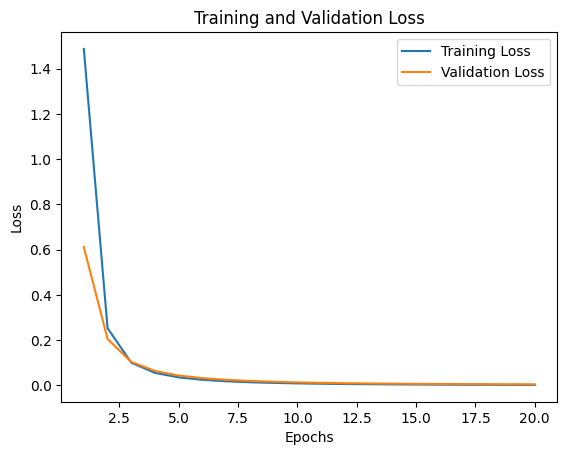

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, 21)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()